## Temporal Differance ( TD(0) )
#### Incremental MC
    * Reccurence formula of average calculation
$$\mu_{k} = \mu_{k-1}+{{1}\over{k}}(x_{k}-\mu_{k-1}) $$
    * MC(stationary)
$$ V(S_{t})\: \leftarrow\:V(S_{t})\:+\:{1\over{N(S)}}\:*\:(G_{t}-V(S_{t}))$$
    * MC(non-stationary)
$$V(S_{t})\: \leftarrow\:V(S_{t})\:+\:\alpha\:*\:(G_{t}-V(S_{t}))$$
#### TD(0)
    * Instead of waiting utill simulation finishes, update value function step by step

$$V(S_{t})\: \leftarrow\:V(S_{t})\:+\:\alpha\:*\:(R_{t+1}\:+\:\gamma V(S_{t+1})-V(S_{t}))$$
    * TD target is bias estimation of real $G_{t}$ and has low variance  

## Source Code 
#### Grid World Enviroment setting
* states, actions, transition probability

In [1]:
# set state
import numpy as np
nCols = 3
nRows = 4
nWalls = 1
states = []
for i in range(nCols*nRows-nWalls):
    states.append(i)
N_STATES = len(states)
#print(N_STATES)
#print(states)

# set map
map = -np.ones((nCols+2,nRows+2))
for i in range(nCols):
    for j in range(nRows):
        map[i+1,j+1] = 0
map[2,2] = -1 # add wall
#print(map)

# set action
actions = [0, 1, 2, 3]
N_ACTIONS = len(actions)

# states -> location
locations = []
index = 0
for i in range(nCols):
    for j in range(nRows):
        if map[i+1,j+1]==0:
            locations.append((i+1,j+1))
            index = index + 1
#print(locations) # match index with states
# action -> move
move = [(0,-1),(-1,0),(0,1),(1,0)] # match index with actions
#print(move)

# set transition probability
P = np.zeros((N_STATES,N_ACTIONS,N_STATES)) # P[S,A,S']
for s in range(N_STATES):
    for a in range(N_ACTIONS):
        current_location = locations[s]
        # heading collectly  ####################################################################################
        next_location = (current_location[0] + move[a][0],current_location[1] + move[a][1])
        
        if map[next_location[0],next_location[1]] == -1: # there is barrier or wall
            next_location = current_location
            next_s = states[locations.index(next_location)]
        else:
            next_s = states[locations.index(next_location)]
        P[s,a,next_s] = P[s,a,next_s] + 0.8
        # left error ############################################################################################
        next_location = (current_location[0] + move[a-1][0],current_location[1] + move[a-1][1])
        if map[next_location[0],next_location[1]] == -1: # there is barrier or wall
            next_location = current_location
            next_s = states[locations.index(next_location)]
        else:
            next_s = states[locations.index(next_location)]
        P[s,a,next_s] = P[s,a,next_s] + 0.1
        # right error ############################################################################################
        next_location = (current_location[0] + move[(a+1)%4][0],current_location[1] + move[(a+1)%4][1])
        
        if map[next_location[0],next_location[1]] == -1: # there is barrier or wall
            next_location = current_location
            next_s = states[locations.index(next_location)]
        else:
            next_s = states[locations.index(next_location)]
        P[s,a,next_s] = P[s,a,next_s] + 0.1
        
# rewards s,a ---  R(s,a)  ---> s'
if True:
    R = -0.02*np.ones((N_STATES,N_ACTIONS))
else:
    R = -0.5*np.ones((N_STATES,N_ACTIONS))
R[3,:] = 1
R[6,:] = -1
#print(R)
# discount factor
gamma = 0.99

# policy : given state which action would u choose
# assume that we know the policy
bad_policy = np.zeros((N_STATES,N_ACTIONS))
bad_policy[0,2] = 1
bad_policy[1,2] = 1
bad_policy[2,2] = 1
bad_policy[3,2] = 1
bad_policy[4,3] = 1
bad_policy[5,2] = 1
bad_policy[6,2] = 1
bad_policy[7,2] = 1
bad_policy[8,2] = 1
bad_policy[9,2] = 1
bad_policy[10,1] = 1

random_policy = 0.25*np.ones((N_STATES,N_ACTIONS))

optimal_policy = np.zeros((N_STATES,N_ACTIONS))
optimal_policy[0,2] = 1
optimal_policy[1,2] = 1
optimal_policy[2,2] = 1
optimal_policy[3,2] = 1
optimal_policy[4,1] = 1
optimal_policy[5,1] = 1
optimal_policy[6,1] = 1
optimal_policy[7,1] = 1
optimal_policy[8,0] = 1
optimal_policy[9,0] = 1
optimal_policy[10,0] = 1
#print(optimal_policy)

optimalWithNoise_policy = np.zeros((N_STATES,N_ACTIONS))
ep = 0.1
optimalWithNoise_policy[0,2] = 1
optimalWithNoise_policy[1,2] = 1
optimalWithNoise_policy[2,2] = 1
optimalWithNoise_policy[3,2] = 1
optimalWithNoise_policy[4,1] = 1
optimalWithNoise_policy[5,1] = 1
optimalWithNoise_policy[6,1] = 1
optimalWithNoise_policy[7,1] = 1
optimalWithNoise_policy[8,0] = 1
optimalWithNoise_policy[9,0] = 1
optimalWithNoise_policy[10,0] = 1
optimalWithNoise_policy = optimalWithNoise_policy + (ep/4)*np.ones((N_STATES,N_ACTIONS))
optimalWithNoise_policy = optimalWithNoise_policy / np.sum(optimalWithNoise_policy,axis = 1).reshape((N_STATES,1))

In [6]:
## TD(0) for V

## set Hyper parameters
epoch = 10000
alpha = 0.01

## set boundary condition
V = np.zeros(N_STATES)
V[3] = 1.0; #goal
V[6] = -1.0; #fail
## states
terminal_states =[3,6]
start_states = [x for x in states if x not in terminal_states]
## set policy
policy = optimalWithNoise_policy

for _ in range(epoch):
    done = False
    s = np.random.choice(start_states) # random initial state
    while not done:
        # s,a,r,s'
        a = np.random.choice(actions,p=policy[s,:])
        reward = R[s,a]
        s1 = np.random.choice(states,p=P[s,a,:])
        TD_target = reward + gamma * V[s1]
        V[s] += alpha*(TD_target-V[s])
        if (s1==3) or (s1==6):
            done = True
        else:
            s = s1
        
        
print(V)

[ 0.84046699  0.88441946  0.93015651  1.          0.80097982  0.6286222
 -1.          0.75563874  0.7113231   0.66695245  0.39903267]


In [7]:
## TD(0) for Q
## set Hyper parameters
epoch = 10000
alpha = 0.01

## set boundary condition
Q = np.zeros((N_STATES,N_ACTIONS))
Q[3,:] = 1.0; #goal
Q[6,:] = -1.0; #fail
## states
terminal_states =[3,6]
start_states = [x for x in states if x not in terminal_states]
## set policy
policy = optimalWithNoise_policy

for _ in range(epoch):
    done = False
    s = np.random.choice(start_states) # random initial state
    a = np.random.choice(actions,p=policy[s,:]) # random initial action
    while not done:
        # s,a,r,s',a'
        reward = R[s,a]
        s1 = np.random.choice(states,p=P[s,a,:])
        a1 = np.random.choice(actions,p=policy[s1,:])
        TD_target = reward + gamma * Q[s1,a1]
        Q[s,a] += alpha*(TD_target-Q[s,a])
        if (s1==3) or (s1==6):
            done = True
        else:
            s = s1
            a = a1
        
        
print(Q)

[[ 0.61745194  0.64023545  0.81453473  0.58264851]
 [ 0.66269388  0.73014471  0.88158222  0.7234077 ]
 [ 0.74498349  0.84901116  0.93133556  0.59478868]
 [ 1.          1.          1.          1.        ]
 [ 0.5576531   0.76069636  0.56760348  0.49817596]
 [ 0.33269092  0.72889241 -0.38937343  0.14097668]
 [-1.         -1.         -1.         -1.        ]
 [ 0.38444297  0.69974505  0.38594563  0.40759923]
 [ 0.62660055  0.33330352  0.28276478  0.31925542]
 [ 0.58313233  0.19011686  0.11862784  0.15427725]
 [ 0.30141308 -0.26773705  0.02977535  0.06046637]]


## TD($\lambda$)
#### Forward View(offline)
    * Gemetry sumation of goal(Expected cummulative reward)
$$G_{t}^{\lambda}    = (1-\lambda)
    \sum_{n=1}^{\infty} \lambda^{n-1}G_{t}^{(n)}$$
$$V(S_{t})\: \leftarrow\:V(S_{t})\:+\:\alpha\:*\:(G_{t}^{\lambda}-V(S_{t}))$$
    * it is hard to implement with this form(high complexity and memory uses)
#### Backward View(online)
    * Eligibility traces
$$ E_{t}(s) = \gamma \lambda E_{t-1}(s)+1(S=S_{t})$$
    
    * TD lambda
$$V(S) \leftarrow V(S)+ \alpha \delta_{t} E_{t}(S) $$  
<center>  </center>
<center>where $\delta_{t} = R_{t+1}\:+\:\gamma V(S_{t+1})-V(S_{t})$</center>

In [24]:
## TD(lamda) for V

## set Hyper parameters
epoch = 1000
alpha = 0.01
lam = 0.5

## set boundary condition
V = np.zeros(N_STATES)
V[3] = 1.0; #goal
V[6] = -1.0; #fail

## states
terminal_states =[3,6]
start_states = [x for x in states if x not in terminal_states]
## set policy
policy = optimalWithNoise_policy
E_history = np.zeros((100,N_STATES))
for _ in range(epoch):
    done = False
    
    #set Eligibilty traces
    E = np.zeros(N_STATES)
    
    s = np.random.choice(start_states) # random initial state
    t = 1
    while not done:
        # s,a,r,s'
        a = np.random.choice(actions,p=policy[s,:])
        reward = R[s,a]
        s1 = np.random.choice(states,p=P[s,a,:])
        

        TD_target = reward + gamma * V[s1]
        TD_error = TD_target-V[s]
        E[s]+=1
        
        for state in start_states:
            V[state] += alpha*TD_error*E[state]
            E[state] = gamma*lam*E[state]
        E_history[t,:]=E 
        t +=1
    
        if (s1==3) or (s1==6):
            done = True
            
        else:
            s = s1
           
        
print(V)

[ 0.82404641  0.87511183  0.90877397  1.          0.77377534  0.63092728
 -1.          0.67951805  0.54813844  0.35964612  0.09207757]


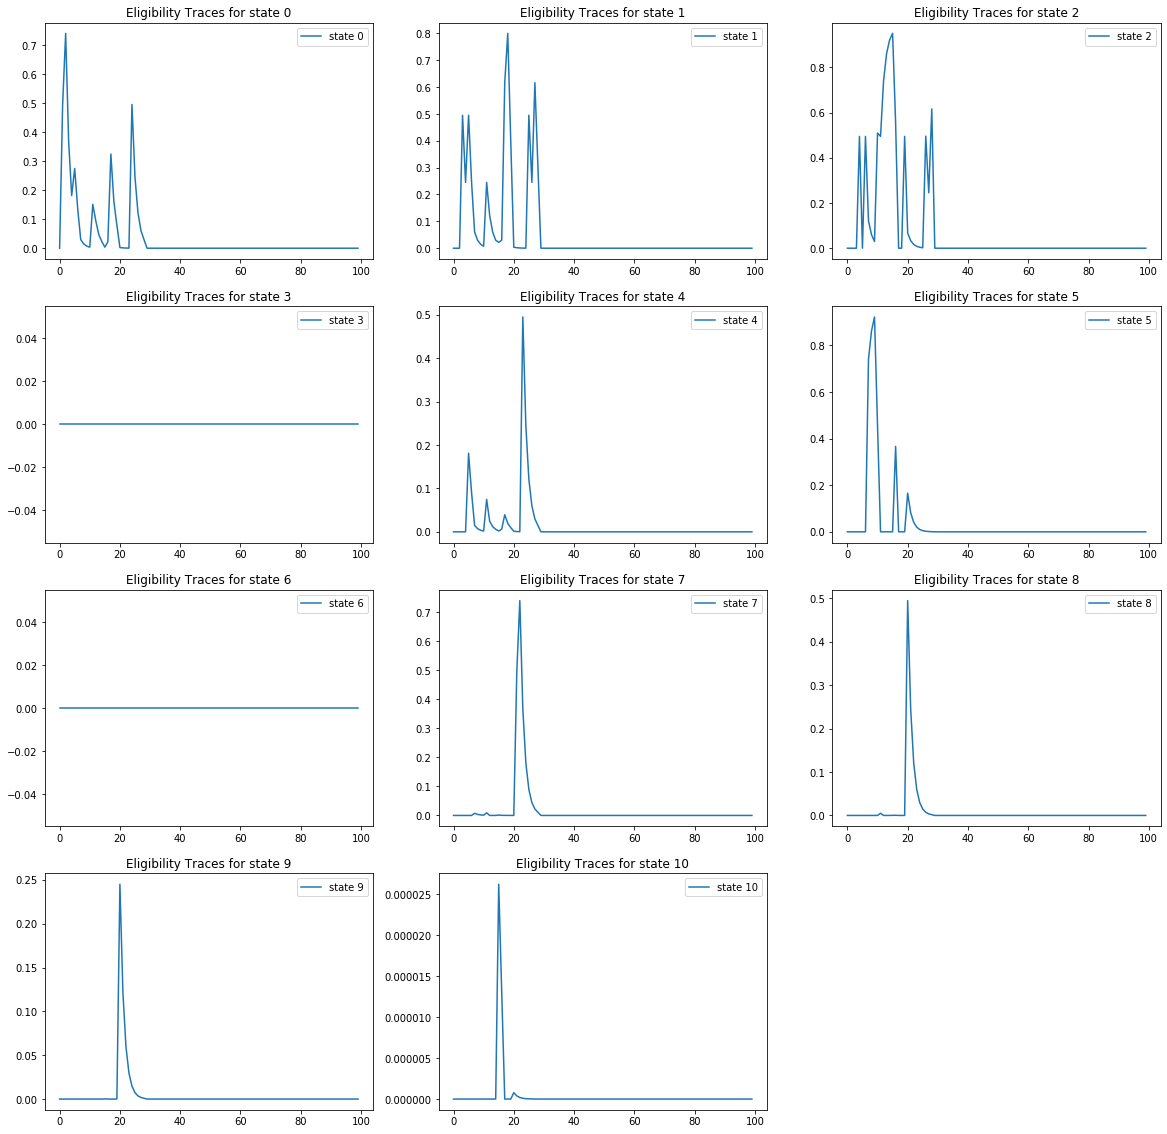

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 20)) 

for i in states:
    plt.subplot(4,3,i+1).set_title("Eligibility Traces for state {}".format(str(i)))
    plt.plot(E_history[:,i])
    plt.legend(['state {}'.format(str(i))])

plt.show()

In [21]:
## TD(lamda) for V

## set Hyper parameters
epoch = 5000
alpha = 0.01
lam = 0.5

## set boundary condition
Q = np.zeros((N_STATES,N_ACTIONS))
Q[3,:] = 1.0; #goal
Q[6,:] = -1.0; #fail

## states
terminal_states =[3,6]
start_states = [x for x in states if x not in terminal_states]
## set policy
policy = optimalWithNoise_policy

for _ in range(epoch):
    done = False
    
    #set Eligibilty traces
    E = np.zeros((N_STATES,N_ACTIONS))
    
    s = np.random.choice(start_states) # random initial state
    a = np.random.choice(actions,p=policy[s,:]) # random initial action
    while not done:
        # s,a,r,s',a'
        
        reward = R[s,a]
        s1 = np.random.choice(states,p=P[s,a,:])
        a1 = np.random.choice(actions,p=policy[s1,:])

        TD_target = reward + gamma * Q[s1,a1]
        TD_error = TD_target - Q[s,a]
        E[s,a]+=1
        
        for state in start_states:
            for action in actions:
                Q[state,action] += alpha*TD_error*E[state,action]
                E[state,action] = gamma*lam*E[state,action]
                
        if (s1==3) or (s1==6):
            done = True
        else:
            s = s1
            a = a1
           
        
print(Q)

[[ 0.51189967  0.44066408  0.79714176  0.40361248]
 [ 0.50289966  0.51636085  0.85447292  0.57671915]
 [ 0.60106147  0.67359323  0.91931738  0.47076323]
 [ 1.          1.          1.          1.        ]
 [ 0.40873809  0.74319264  0.39912164  0.33515651]
 [ 0.1997753   0.58328708 -0.21326994  0.10110476]
 [-1.         -1.         -1.         -1.        ]
 [ 0.30502827  0.69014794  0.23696462  0.28436913]
 [ 0.62565197  0.20839876  0.17910879  0.24591319]
 [ 0.56844719  0.16295257  0.05496183  0.11057138]
 [ 0.32175622 -0.08734758  0.02597747  0.02059574]]
